<a href="https://colab.research.google.com/github/HuiningLiu02/TIF360-Advanced-machine-learning-with-neural-networks/blob/main/Ch03_CNN/hw/particle_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localizing Microscopic Particles


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch03_CNN/ec03_B_particle_localization/particle_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
  

This notebook provides you with a complete code example that trains a convolutional neural network with a dense top using annotated and simulated data and then applies it to experimental videos of an optically trapped particle.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 3-B from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Videos

Download the `particle_dataset`. This folder contains two videos with an optically trapped particle. One video is acquired with very low noise (`low_noise.avi`), while the other with very high noise (`high_noise.avi`).

In [6]:
import os

if not os.path.exists("particle_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/particle_dataset")

Load these videos ...

In [7]:
import cv2
import numpy as np

def load_video(path, frames_to_load, image_size):
    """Load video."""
    video = cv2.VideoCapture(path)

    data = []
    for _ in range(frames_to_load):
        _, frame = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)

    return np.array(data)

In [8]:
image_size = 51
video_low_noise = \
    load_video(os.path.join("particle_dataset", "low_noise.avi"),
               frames_to_load=100, image_size=image_size)
video_high_noise = \
    load_video(os.path.join("particle_dataset", "high_noise.avi"),
               frames_to_load=100, image_size=image_size)

... and plot some of the frames.

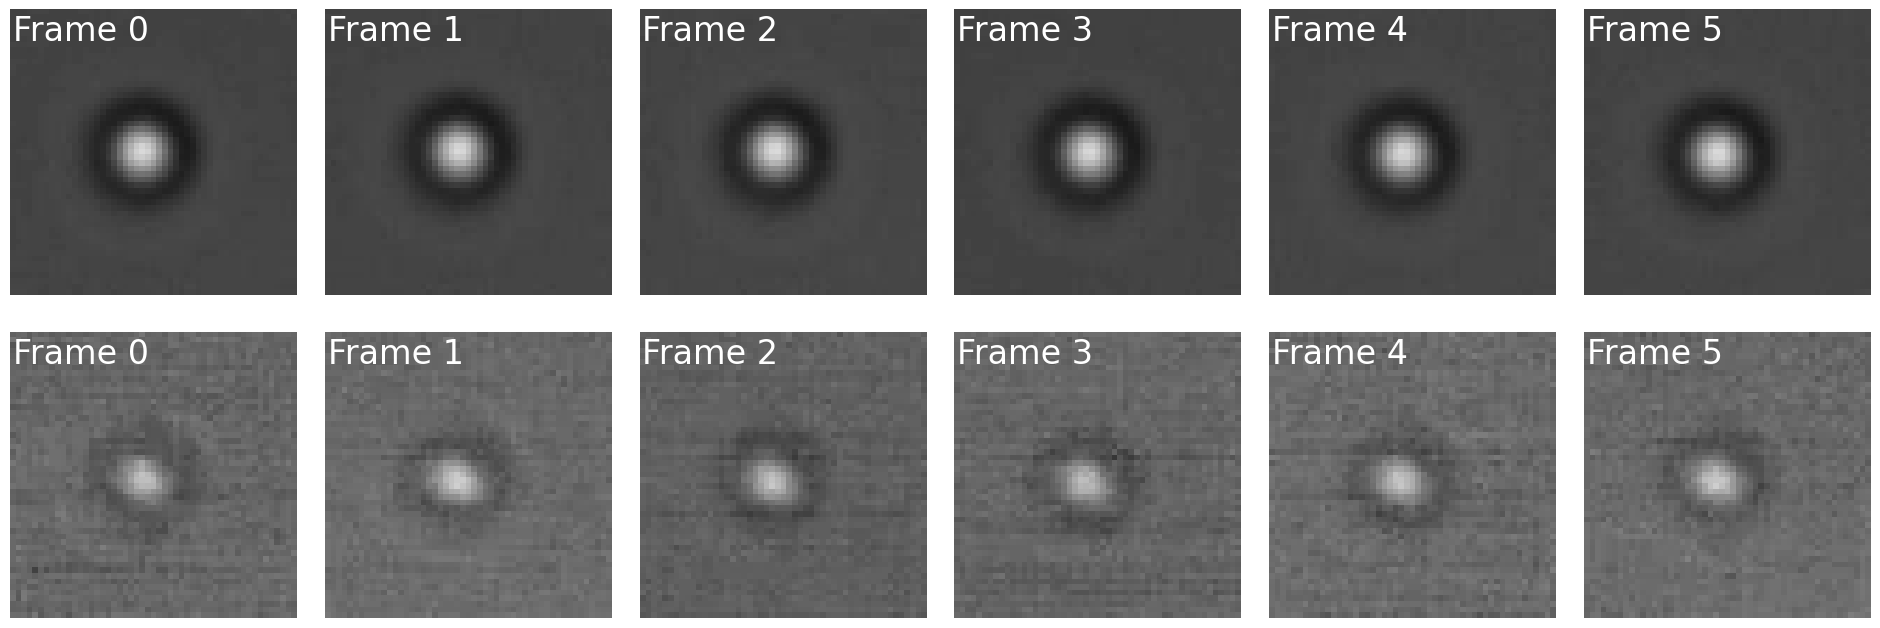

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 6, figsize=(24, 8))
for i in range(6):
    axs[0, i].imshow(video_low_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[0, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[0, i].axis("off")

    axs[1, i].imshow(video_high_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[1, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[1, i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### Preprocessing the Annotated Data

Define a custom dataset ...

In [ ]:
import torch

class AnnotatedDataset(torch.utils.data.Dataset):
    """Manually annotated dataset."""

    def __init__(self, file_images, file_positions):
        """Load annotated images and manual positions."""
        self.images = np.load(file_images)
        self.positions = np.load(file_positions)

    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]

    def __getitem__(self, idx):
        """Get next image and annotated position."""
        im = torch.tensor(self.images[idx, np.newaxis, :, :]).float()
        pos = torch.tensor(self.positions[idx] / im.shape[-1] - 0.5).float()
        return [im, pos]

... create an instance of the dataset with the data you've annotated ...

In [ ]:
ann_dataset = AnnotatedDataset(file_images="annotated_images.npy",
                               file_positions="manual_positions.npy")

... and use it to create the data loaders.

In [ ]:
import deeplay as dl

train_ann_dataset, test_ann_dataset = \
    torch.utils.data.random_split(ann_dataset, [0.8, 0.2])

train_ann_dataloader = dl.DataLoader(train_ann_dataset, batch_size=1)
test_ann_dataloader = dl.DataLoader(test_ann_dataset, batch_size=1)

## Implementing a Convolutional Neural Network for Classification

Sefine a convolutional neural network with a dense top ...

In [ ]:
cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1, hidden_channels=[16, 32], out_channels=64,
        pool=torch.nn.MaxPool2d(kernel_size=2), out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(torch.nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64, hidden_features=[32, 32], out_features=1,
        out_activation=torch.nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
  )
  (1): Layer[MaxPool2d](kernel_size=2)
  (2): Layer[Flatten]()
  (3): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=2304, out_features=32, bias=True)
        (activa

... and compile it for a regression task.

In [ ]:
from torchmetrics import MeanAbsoluteError as MAE

cnn_regressor_template = dl.Regressor(
    model=cnn, loss=torch.nn.MSELoss(), optimizer=dl.Adam(), metrics=[MAE()],
)
cnn_ann_regressor = cnn_regressor_template.create()

print(cnn_ann_regressor)

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64,

## Training the Neural Network with Annotated Data

In [ ]:
cnn_ann_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_ann_trainer.fit(cnn_ann_regressor, train_ann_dataloader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss          │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ Sequential       │ 98.2 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 98.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 98.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 34                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


### Testing the Trained Neural Network

In [ ]:
test_ann_results = cnn_ann_trainer.test(cnn_ann_regressor, test_ann_dataloader)
MAE_ann = test_ann_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_ann:.3f} pixels")

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMeanAbsoluteError_epoch │     0.00956819113343954     │
│       test_loss_epoch       │   0.00012557723675854504    │
└─────────────────────────────┴─────────────────────────────┘

Mean pixel error (MAE): 0.488 pixels


### Visualizing the Predictions

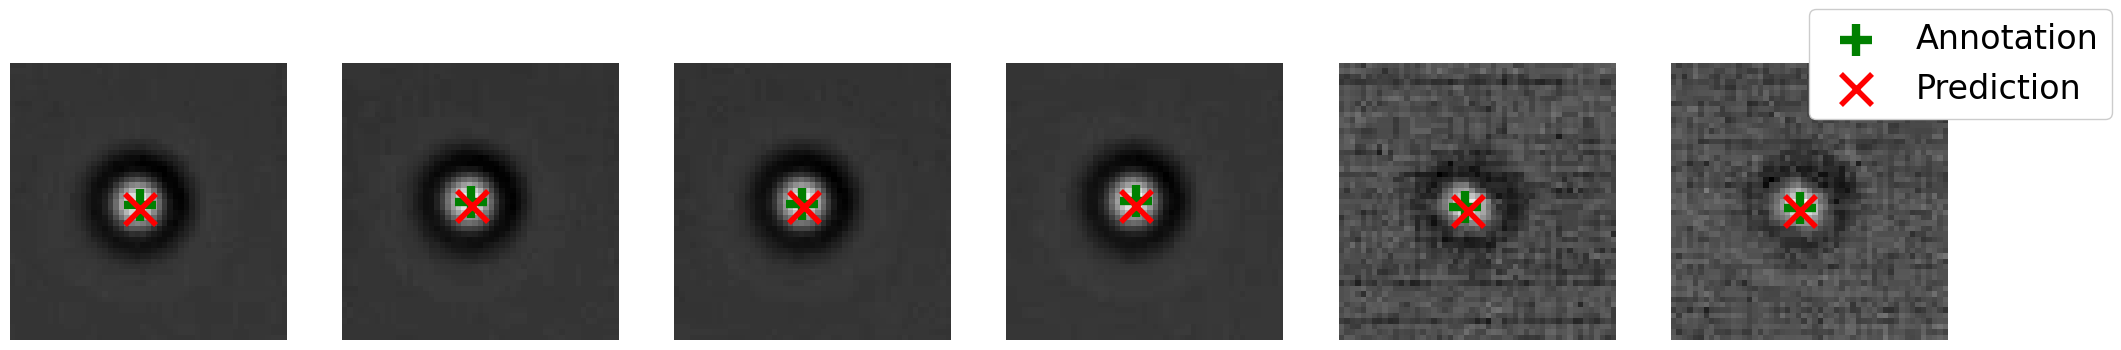

In [ ]:
indices = np.random.choice(np.arange(len(test_ann_dataset)), 6, replace=False)
images = [test_ann_dataset[index][0] for index in indices]
annotations = [test_ann_dataset[index][1] for index in indices]
predictions = cnn_ann_regressor(torch.stack(images))

fig, axs = plt.subplots(1, 6, figsize=(25, 8))
for ax, im, ann, pred in zip(axs, images, annotations, predictions):
    ax.imshow(im.numpy().squeeze(), cmap="gray")

    ann = ann * image_size + image_size / 2
    ax.scatter(ann[0], ann[1], marker="+", c="g", s=500, linewidth=6,
               label="Annotation")

    pred = pred.detach().numpy() * image_size + image_size / 2
    ax.scatter(pred[0], pred[1], marker="x", c="r", s=500, linewidth=4,
               label="Prediction")

    ax.set_axis_off()
ax.legend(loc=(0.5, 0.8), framealpha=1, fontsize=24)
plt.show()

## Simulating the Training Data

Define the particle ...

In [4]:
import deeptrack as dt

particle = dt.scatterers.MieSphere(
    position=lambda: np.random.uniform(image_size / 2 - 5,
                                       image_size / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, 1),
    radius=lambda: np.random.uniform(400, 800) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)

... specify the optical device to image the particle ...

In [15]:
brightfield_microscope = dt.optics.Brightfield(
    wavelength=630e-9, NA=0.8, resolution=1e-6, magnification=15,
    refractive_index_medium=1.33, output_region=(0, 0, image_size, image_size),
)

... combine them ...

In [16]:
imaged_particle = brightfield_microscope(particle)

... and plot them.

In [17]:
def plot_simulated_particles(image_pipeline):
    """Plot simulated particles."""
    fig, axs = plt.subplots(1, 6, figsize=(25, 8))
    for i, ax in enumerate(axs.flatten()):
        image = image_pipeline.update().resolve()
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

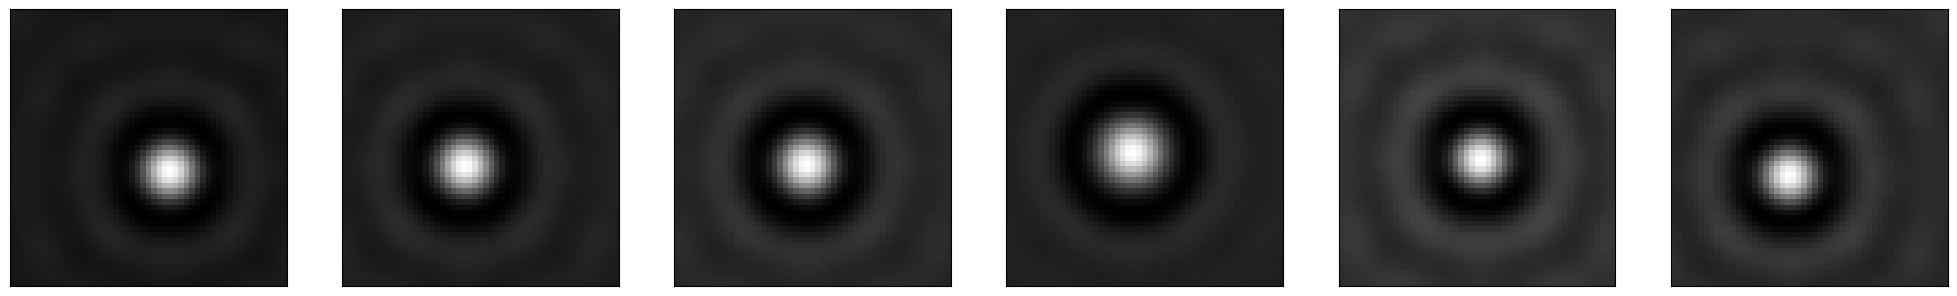

In [18]:
plot_simulated_particles(imaged_particle)

### Creating Images of Particles with Noise

Adding a Poisson noise source to the simulation pipeline ...

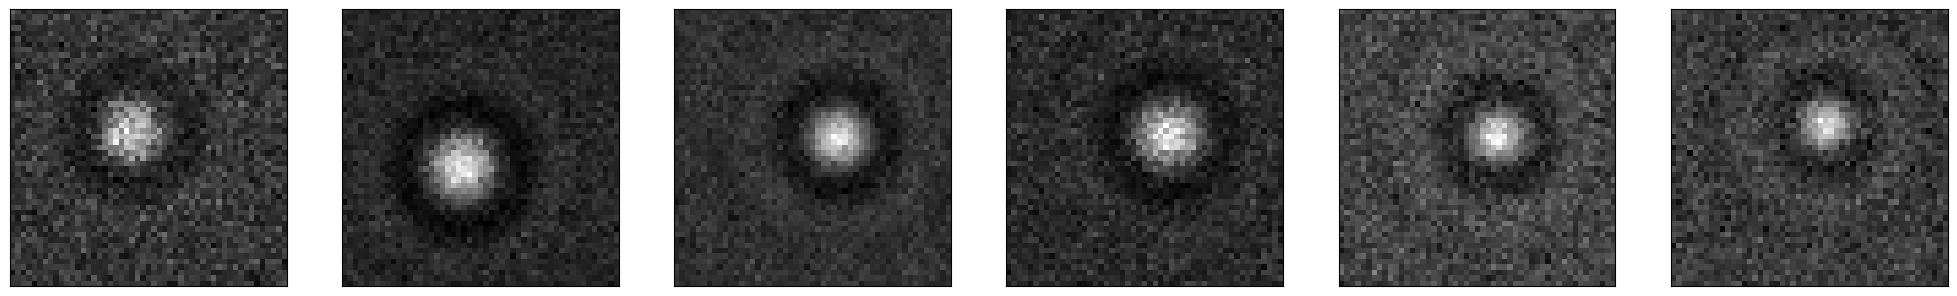

In [19]:
noise = dt.Poisson(
    min_snr=5, max_snr=20, background=1,
    snr=lambda min_snr, max_snr: np.random.uniform(min_snr, max_snr),
)
noisy_imaged_particle = imaged_particle >> noise

plot_simulated_particles(noisy_imaged_particle)

... and create a pipeline that generates noisy particle images and normalize the pixel values.

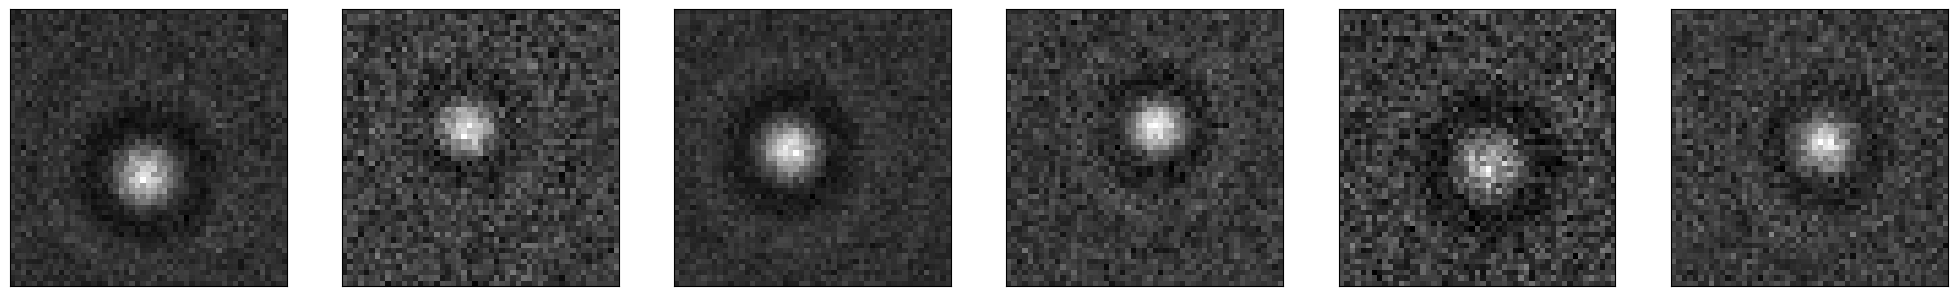

In [20]:
normalization = dt.NormalizeMinMax(lambda: np.random.uniform(0.0, 0.2),
                                   lambda: np.random.uniform(0.8, 1.0))
image_pipeline = noisy_imaged_particle >> normalization

plot_simulated_particles(image_pipeline)

### Getting the Positions from the Simulated Images

Define a pipeline to obtain both the particle image and its centroid position ...

In [28]:
pipeline = image_pipeline & particle.radius

... and plot the particle positions on top of the particle images.

In [22]:
def plot_simulated_particles_with_positions(pipeline):
    """Plot simulated particles with positions."""
    fig, axs = plt.subplots(1, 6, figsize=(25, 8))
    for i, ax in enumerate(axs.flatten()):
        image, position = pipeline.update().resolve()
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.scatter(position[1], position[0], s=500, facecolors="none",
                   edgecolors="g", linewidth=6)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

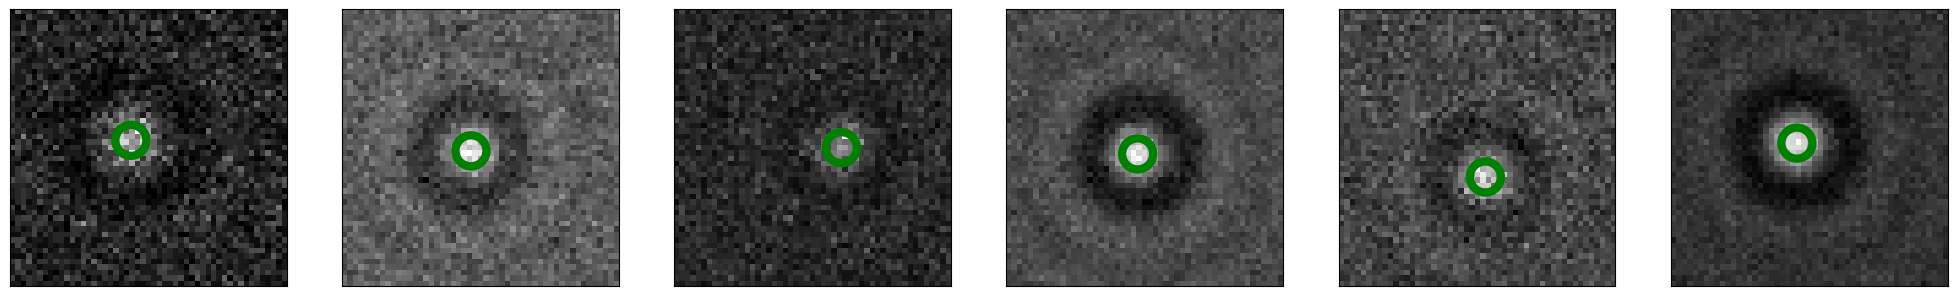

In [23]:
plot_simulated_particles_with_positions(pipeline)

### Preprocessing the Simulated Data

Create a database to work with the simulated particle images ...

In [34]:
import torch
class SimulatedDataset(torch.utils.data.Dataset):
    """Dataset with simulated particles."""

    def __init__(self, pipeline, data_size):
        """Initialize simulated dataset."""
        images, sizes = [], []
        for _ in range(data_size):
            image, radius = pipeline.update().resolve()
            images.append(image),
            sizes.append(radius)
        self.images, self.sizes = np.array(images), np.array(sizes)

    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]

    def __getitem__(self, idx):
        """Get next simulated image and position."""
        im = torch.tensor(self.images[idx]).float().permute(2, 0, 1)
        size = torch.tensor(self.sizes[idx] / 1e-6).float().unsqueeze(0)
        return [im, size]

... and create the training and test data loaders.

In [35]:
import deeplay as dl
train_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=10_000), batch_size=32,
)
test_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=100), batch_size=32,
)

## Implementing a Convolutional Neural Network for Classification

Sefine a convolutional neural network with a dense top ...

In [31]:
cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1, hidden_channels=[16, 32], out_channels=64,
        pool=torch.nn.MaxPool2d(kernel_size=2), out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(torch.nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64, hidden_features=[32, 32], out_features=1,
        out_activation=torch.nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
  )
  (1): Layer[MaxPool2d](kernel_size=2)
  (2): Layer[Flatten]()
  (3): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=2304, out_features=32, bias=True)
        (activa

In [32]:
from torchmetrics import MeanAbsoluteError as MAE

cnn_regressor_template = dl.Regressor(
    model=cnn, loss=torch.nn.MSELoss(), optimizer=dl.Adam(), metrics=[MAE()],
)
cnn_ann_regressor = cnn_regressor_template.create()

print(cnn_ann_regressor)

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64,

## Training the Neural Network with Simulated Data

In [36]:
cnn_sim_regressor = cnn_regressor_template.create()
cnn_sim_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_sim_trainer.fit(cnn_sim_regressor, train_sim_dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 98.1 K | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
98.1 K    Trainable params
0         Non-trainable params
98.1 K    Total params
0.393     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

In [44]:
torch.save(cnn_sim_regressor.state_dict(), 'trained_model.pth')

In [46]:
os.makedirs('/content/models', exist_ok=True)
torch.save(cnn_sim_regressor.state_dict(), '/content/models/trained_model.pth')

In [47]:
from google.colab import files
files.download('/content/models/trained_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Testing the Trained Neural Network

In [42]:
test_sim_results = cnn_sim_trainer.test(cnn_sim_regressor, test_sim_dataloader)
MAE_sim = test_sim_results[0]["testMeanAbsoluteError_epoch"]
print(f"Mean pixel error (MAE): {MAE_sim:.3f} µm")

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMeanAbsoluteError_epoch │    0.020175466313958168     │
│       test_loss_epoch       │    0.0006250389851629734    │
└─────────────────────────────┴─────────────────────────────┘

Mean pixel error (MAE): 0.020 µm


### Plotting the Predictions Versus the Ground Truth

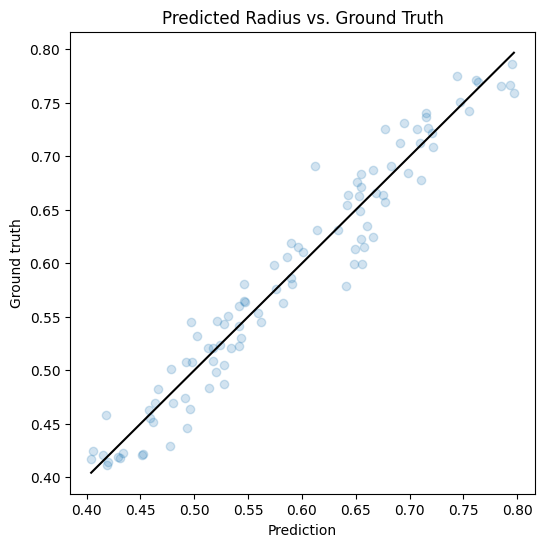

In [41]:
preds, gts = [], []
for image, radius in iter(test_sim_dataloader):
    preds.append(cnn_sim_regressor(image))
    gts.append(radius)
preds = torch.cat(preds, dim=0).detach().numpy()
gts = torch.cat(gts, dim=0).numpy()


plt.figure(figsize=(6, 6))
plt.scatter(gts, preds, alpha=0.2)
plt.plot([np.min(gts), np.max(gts)], [np.min(gts), np.max(gts)], c="k")
plt.xlabel("Prediction")
plt.ylabel("Ground truth")
plt.title("Predicted Radius vs. Ground Truth")
#ax.set_aspect("equal")
#ax.set_xlim([-0.07, 0.07])
#ax.set_ylim([-0.07, 0.07])
#ax.label_outer()
plt.show()

### Comparing with the Annotated Data

In [49]:
from google.colab import files
uploaded = files.upload()

Saving annotated_images.npy to annotated_images.npy


In [61]:
ann_images = np.load("annotated_images.npy")
idx = 0
ann_image = ann_images[idx]
ann_images_tensor = torch.tensor(ann_image).float().unsqueeze(0).unsqueeze(0)

Text(0.5, 1.0, 'annotated image')

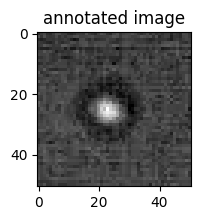

In [60]:
plt.figure(figsize=(2, 2))
plt.imshow(ann_image.squeeze(), cmap="gray")
plt.title("annotated image")

In [52]:
def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)
    plt.show()

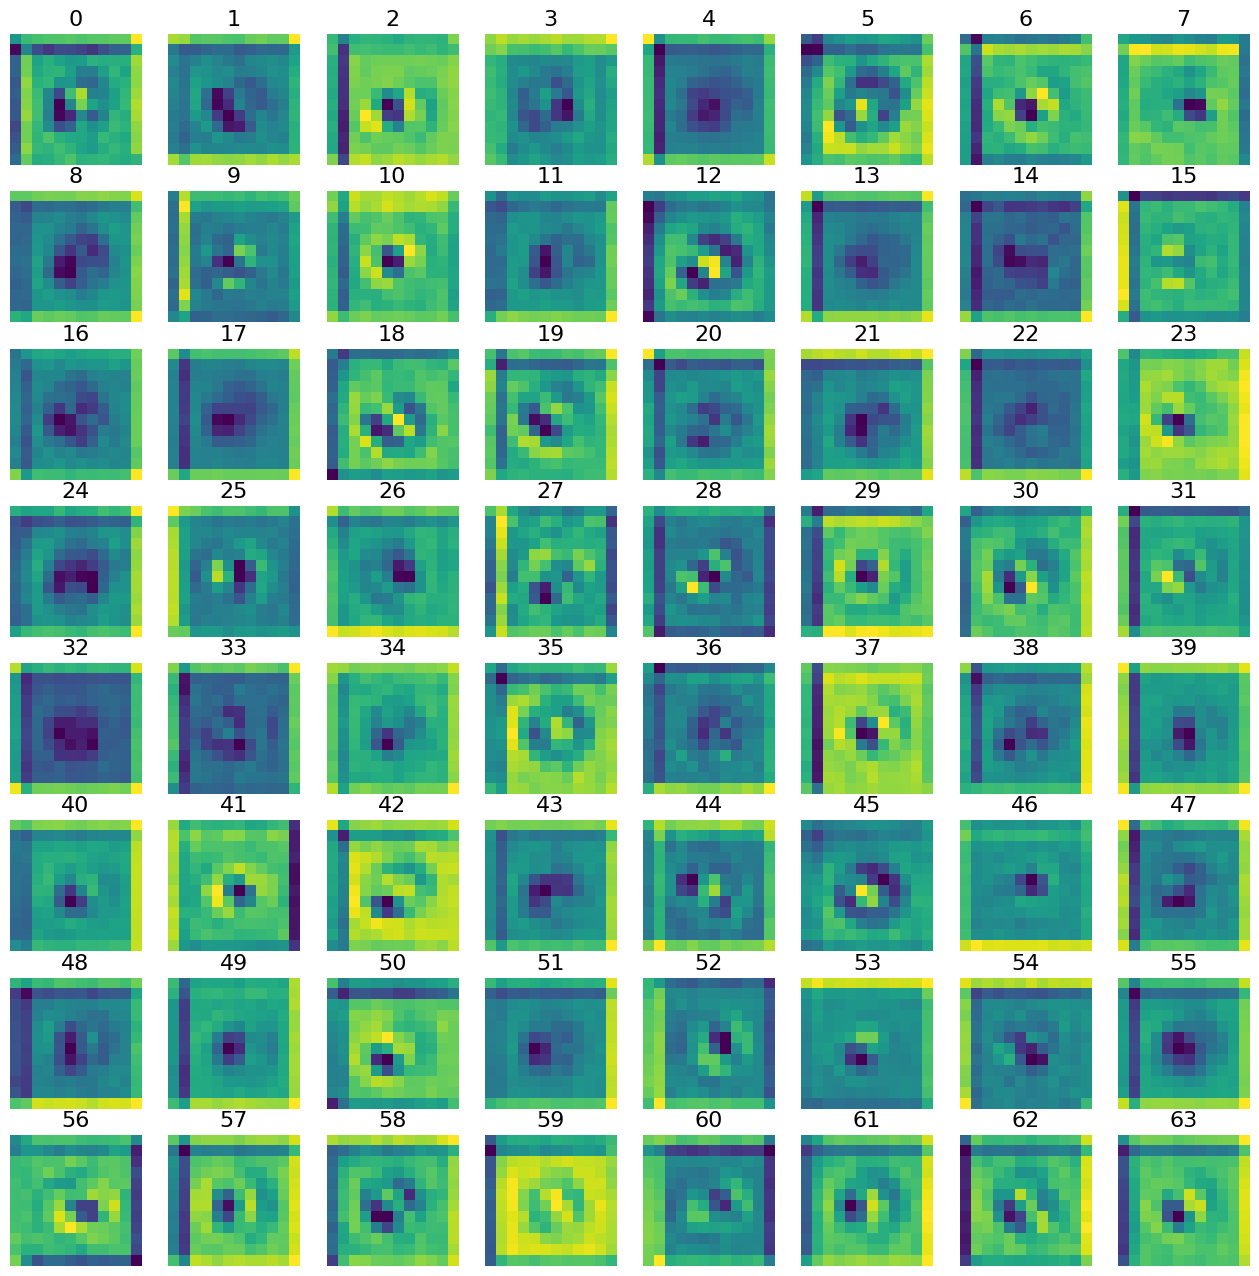

In [55]:
def hook_func(layer, input, output):
  """Hook for activations."""
  activations = output.detach().clone()
  plot_activations(activations[0])


layer = cnn_sim_regressor.model[0].blocks[2].layer
handle_hook = layer.register_forward_hook(hook_func)

try:
  pred = cnn_sim_regressor.model(ann_images_tensor)
except Exception as e:
  print(f"An error occurred during model prediction: {e}")
finally:
  handle_hook.remove()

<ipython-input-69-82fa7dcd57d1>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_images_tensor = torch.tensor(sim_image).float().unsqueeze(0)


Text(0.5, 1.0, 'simulation image')

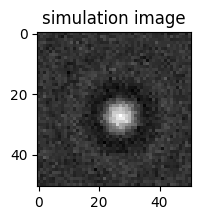

In [69]:
for images, labels in train_sim_dataloader:
  sim_image = images[idx]
sim_images_tensor = torch.tensor(sim_image).float().unsqueeze(0)
plt.figure(figsize=(2, 2))
plt.imshow(sim_image.squeeze(), cmap="gray")
plt.title("simulation image")

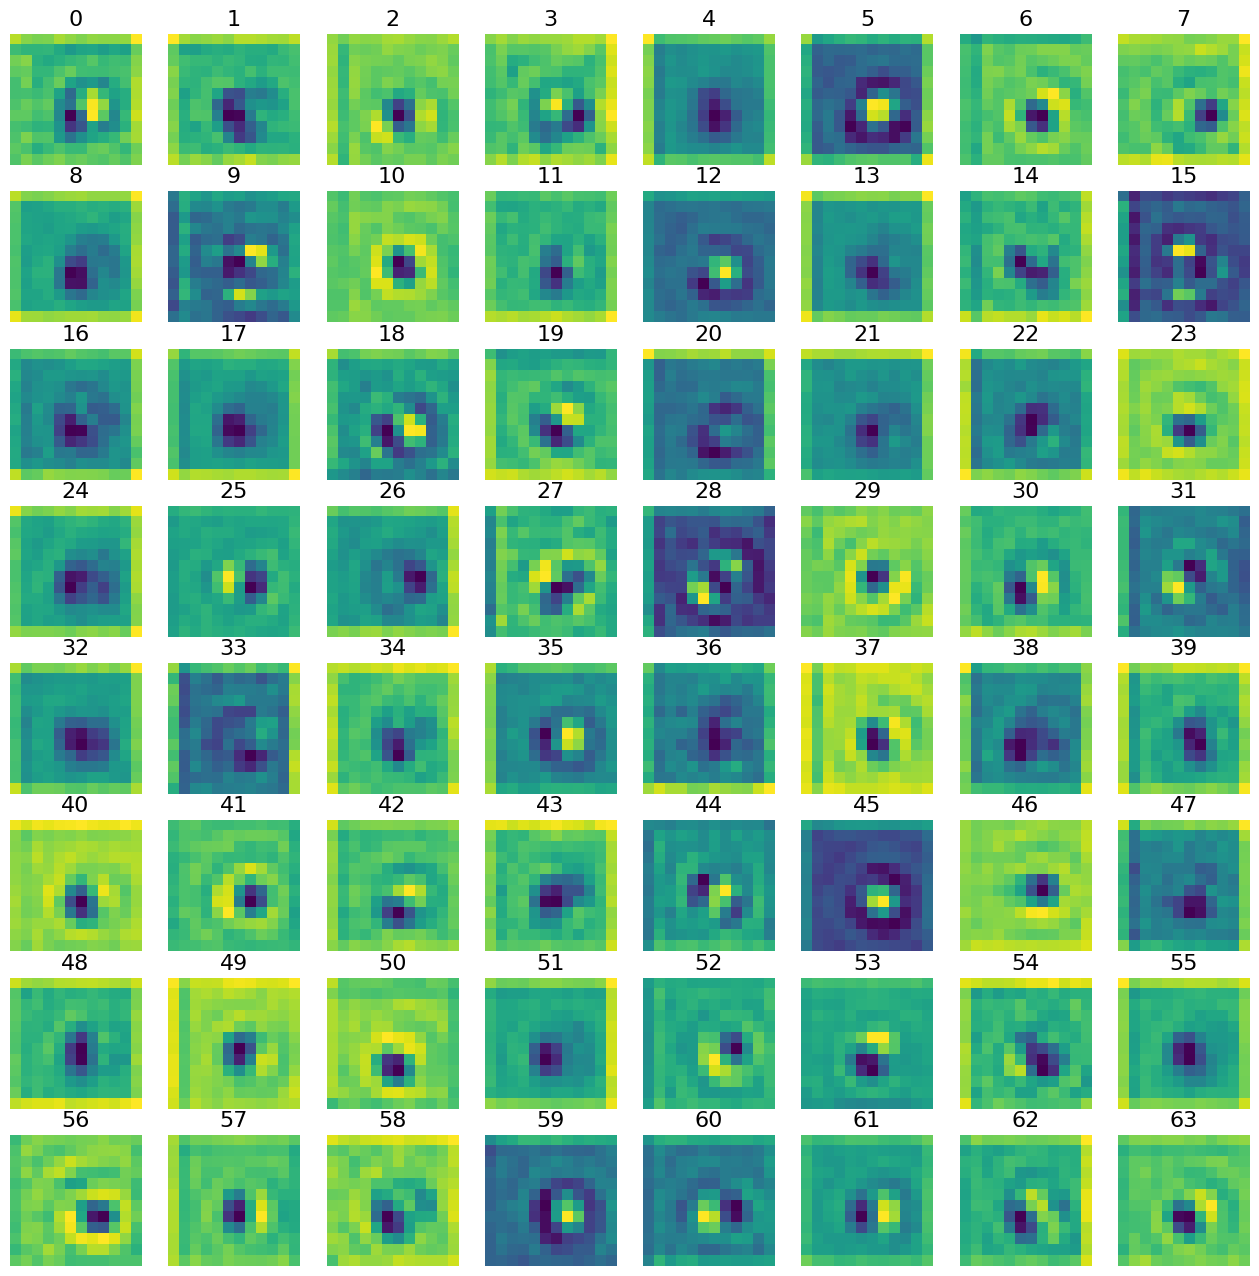

In [70]:
def hook_func(layer, input, output):
  """Hook for activations."""
  activations = output.detach().clone()
  plot_activations(activations[0])


layer = cnn_sim_regressor.model[0].blocks[2].layer
handle_hook = layer.register_forward_hook(hook_func)
try:
  pred = cnn_sim_regressor.model(sim_images_tensor)
except Exception as e:
  print(f"An error occurred during model prediction: {e}")
finally:
  handle_hook.remove()